In [2]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

from matplotlib import gridspec
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/almaz/miniconda3/envs/science/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Расчет

Некоторые константы

In [3]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 7.246 #энергия отрыва нейтрона

total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [4]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [5]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [6]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [7]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

In [8]:
Janecki_Z54 = pd.read_excel('../../fermi_func_tables/from_1968/Janecki Z54.xls')

def Janecki_func2(e_e, Janecki_data=Janecki_Z54):
    #input привиденная энергия электрона 
    e_e3 = np.sqrt( np.square( Janecki_data['p0'].values ) + 1 )
    return np.interp(x = e_e, xp = e_e3, 
                     fp = Janecki_data['Value'])

def Janecki_func(e_e, Janecki_data=Janecki_Z54):
    #input привиденная энергия электрона 
    e_e3 = np.sqrt( np.square( Janecki_data['p0'].values ) + 1 )
    f = interp1d(x=e_e3, y= Janecki_data['Value'], kind='linear', fill_value='extrapolate')
    return f(e_e)

### BS05_OP flux

In [9]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [10]:
#B16-GS98 - high metallicity
B16_GS98_Be = 4.93e9
B16_GS98_pp = 5.98e10
B16_GS98_pep = 1.44e8
B16_GS98_hep = 7.98e3
B16_GS98_B = 5.46e6 
B16_GS98_N = 2.78e8
B16_GS98_0 = 2.05e8
B16_GS98_F = 5.29e6

In [11]:
#B16-AGSS09met - low metallicity
B16_AGSS09met_Be = 4.50e9
B16_AGSS09met_pp = 6.03e10
B16_AGSS09met_pep = 1.46e8
B16_AGSS09met_hep = 8.25e3
B16_AGSS09met_B = 4.50e6 
B16_AGSS09met_N = 2.04e8
B16_AGSS09met_0 = 1.44e8
B16_AGSS09met_F = 3.26e6

In [12]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [13]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [14]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

In [15]:
highZ_flux = return_flux(pp_ampl=B16_GS98_pp, 
                          hep_ampl=B16_GS98_hep,
                          B_ampl=B16_GS98_B,
                          N_ampl=B16_GS98_N,
                          O_ampl=B16_GS98_0,
                          F_ampl=B16_GS98_F)

lowZ_flux = return_flux(pp_ampl=B16_AGSS09met_pp, 
                          hep_ampl=B16_AGSS09met_hep,
                          B_ampl=B16_AGSS09met_B,
                          N_ampl=B16_AGSS09met_N,
                          O_ampl=B16_AGSS09met_0,
                          F_ampl=B16_AGSS09met_F)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [16]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [17]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC, fermi_func):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=fermi_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [18]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

In [19]:
#функция расчета полного сечения, а не dsigma/dE, 
def integrated_cross_sec_calc(sigma, energies_array, step, func_pep_ampl = 1, 
              func_Be_ampl = 1, name = 'test1'):
    
    fluxes_dict = return_flux(pp_ampl=1, 
                          hep_ampl=1,
                          B_ampl=1,
                          N_ampl=1,
                          O_ampl=1,
                          F_ampl=1)
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384 #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

In [20]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [21]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data, fermi_func):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*fermi_func(e_energy/0.511) 

In [22]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [23]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, fermi_func, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y, fermi_func))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

In [24]:
p_list = np.arange(0,20, 0.01) #p = z - Q

### расчет c декомпозицией

In [25]:
decomp = pd.read_excel('127Xe_bgt_decomp.xls')
decomp.head(20)

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2
0,0.00,0.00000,0.014032,0.00000,0.00000,0.00000
1,0.05,0.00018,0.041647,0.00007,0.00004,0.00007
2,0.10,0.00071,0.041647,0.00027,0.00014,0.00030
3,0.15,0.00162,0.089973,0.00061,0.00032,0.00069
4,0.20,0.00288,0.089973,0.00108,0.00057,0.00123
5,0.25,0.00451,0.083343,0.00170,0.00089,0.00192
6,0.30,0.00647,0.058906,0.00246,0.00127,0.00274
7,0.35,0.00877,0.054557,0.00337,0.00171,0.00369
8,0.40,0.01135,0.041694,0.00442,0.00220,0.00473
9,0.45,0.01421,0.035951,0.00563,0.00273,0.00585


In [26]:
trapz(decomp['bgt'].values, decomp['Ex, MeV'].values),\
trapz(decomp['best_fit'].values, decomp['Ex, MeV'].values),\
trapz(decomp['gtr'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr1'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr2'].values, decomp['Ex, MeV'].values),

(55.58062392490359, 55.568871, 52.711257, 2.4391040000000004, 0.41851)

In [27]:
#добавим в best fit кусок с уровнем 125кэВ
decomp['best_fit125'] = decomp['bgt'][(decomp['Ex, MeV'] < 0.4)].append(decomp['best_fit'][decomp['Ex, MeV'] >= 0.4])

In [28]:
trapz(decomp['bgt'].values, decomp['Ex, MeV'].values),\
trapz(decomp['best_fit'].values, decomp['Ex, MeV'].values),\
trapz(decomp['best_fit125'].values, decomp['Ex, MeV'].values),\
trapz(decomp['gtr'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr1'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr2'].values, decomp['Ex, MeV'].values), 

(55.58062392490359,
 55.568871,
 55.59096711646587,
 52.711257,
 2.4391040000000004,
 0.41851)

In [29]:
decomp.head(12)

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2,best_fit125
0,0.00,0.00000,0.014032,0.00000,0.00000,0.00000,0.014032
1,0.05,0.00018,0.041647,0.00007,0.00004,0.00007,0.041647
2,0.10,0.00071,0.041647,0.00027,0.00014,0.00030,0.041647
3,0.15,0.00162,0.089973,0.00061,0.00032,0.00069,0.089973
4,0.20,0.00288,0.089973,0.00108,0.00057,0.00123,0.089973
5,0.25,0.00451,0.083343,0.00170,0.00089,0.00192,0.083343
6,0.30,0.00647,0.058906,0.00246,0.00127,0.00274,0.058906
7,0.35,0.00877,0.054557,0.00337,0.00171,0.00369,0.054557
8,0.40,0.01135,0.041694,0.00442,0.00220,0.00473,0.011350
9,0.45,0.01421,0.035951,0.00563,0.00273,0.00585,0.014210


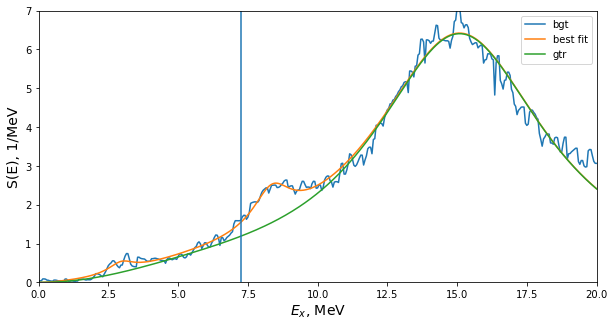

In [30]:
plt.figure(figsize=(10,5))
plt.plot(decomp['Ex, MeV'].values, decomp['bgt'].values, label='bgt')
plt.plot(decomp['Ex, MeV'].values, decomp['best_fit'].values, label='best fit')
plt.plot(decomp['Ex, MeV'].values, decomp['gtr'].values, label='gtr')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.axvline(S_n)
plt.xlim(0,20)
plt.ylim(0,7)
plt.legend()
plt.show()

In [31]:
y_total_border = border_func(decomp['Ex, MeV'].values, decomp['best_fit'].values, S_n)
y_total125_border = border_func(decomp['Ex, MeV'].values, decomp['best_fit125'].values, S_n)
y_bgt_border = border_func(decomp['Ex, MeV'].values, decomp['bgt'].values, S_n)
y_gtr_border = border_func(decomp['Ex, MeV'].values, decomp['gtr'].values, S_n)
y_pr1_border = border_func(decomp['Ex, MeV'].values, decomp['pr1'].values, S_n)
y_pr2_border = border_func(decomp['Ex, MeV'].values, decomp['pr2'].values, S_n)

### y_total + 125 kev level

In [32]:
sigma_y_tot125_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['best_fit125'].values, Janecki_func, 200) for p in p_list]
sigma_y_tot125_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_tot125_no_border_temp)

sigma_y_tot125_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_total125_border, Janecki_func, 200) for p in p_list]
sigma_y_tot125_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_tot125_border_temp)

In [33]:
### BS05OP
rate_calc(sigma_y_tot125_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 27.888723896409623,
 'hep': 0.1171220197919852,
 'n13': 0.16766221195857162,
 'o15': 0.5138729574266955,
 'f17': 0.01301976135155233,
 'pep': 0.7423962258433823,
 'Be': 3.0308811932751625,
 'Total': 32.47367826605697}

In [34]:
rate_calc(sigma_y_tot125_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 33.23234245086451,
 'hep': 0.2038885453796457,
 'n13': 0.16766221195857162,
 'o15': 0.5138729574266955,
 'f17': 0.01301976135155233,
 'pep': 0.7423962258433823,
 'Be': 3.0308811932751625,
 'Total': 37.90406334609952}

In [35]:
rate_calc(sigma_y_tot125_no_border_full - sigma_y_tot125_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.343618554454883,
 'hep': 0.08676652558766051,
 'n13': 0.0,
 'o15': 0.0,
 'f17': 0.0,
 'pep': 0.0,
 'Be': 0.0,
 'Total': 5.4303850800425435}

In [36]:
integrated_cross_sec_calc(sigma_y_tot125_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 4.9013574510385984e-42,
 'hep': 1.4769485471877074e-41,
 'n13': 5.461309835784091e-46,
 'o15': 2.2054633365952598e-45,
 'f17': 2.229411190334303e-45,
 'pep': 5.228142435516776e-45,
 'Be': 6.262151225775129e-46,
 'Total': 1.9681678285984274e-41}

In [37]:
integrated_cross_sec_calc(sigma_y_tot125_no_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.840481977304834e-42,
 'hep': 2.5711039770447123e-41,
 'n13': 5.461309835784091e-46,
 'o15': 2.2054633365952598e-45,
 'f17': 2.229411190334303e-45,
 'pep': 5.228142435516776e-45,
 'Be': 6.262151225775129e-46,
 'Total': 3.156235711082056e-41}

In [38]:
#B16-AGSS09met lowZ model 
rate_calc(sigma_y_tot125_border_full, \
          lowZ_flux, Energy_all_fluxes, step_all_fluxes, B16_AGSS09met_pep, B16_AGSS09met_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 22.056108529673697,
 'hep': 0.12184825514298586,
 'n13': 0.11141072064999546,
 'o15': 0.31758672046971737,
 'f17': 0.007267880480489828,
 'pep': 0.7633087955854493,
 'Be': 2.817968051598808,
 'Total': 26.195498953601142}

In [39]:
rate_calc(sigma_y_tot125_no_border_full - sigma_y_tot125_border_full, \
          lowZ_flux, Energy_all_fluxes, step_all_fluxes, B16_AGSS09met_pep, B16_AGSS09met_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 4.226060368198062,
 'hep': 0.09026782296320293,
 'n13': 0.0,
 'o15': 0.0,
 'f17': 0.0,
 'pep': 0.0,
 'Be': 0.0,
 'Total': 4.316328191161265}

In [40]:
rate_calc(sigma_y_tot125_no_border_full, \
          lowZ_flux, Energy_all_fluxes, step_all_fluxes, B16_AGSS09met_pep, B16_AGSS09met_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 26.28216889787176,
 'hep': 0.21211607810618877,
 'n13': 0.11141072064999546,
 'o15': 0.31758672046971737,
 'f17': 0.007267880480489828,
 'pep': 0.7633087955854493,
 'Be': 2.817968051598808,
 'Total': 30.511827144762407}

In [41]:
a = rate_calc(sigma_y_tot125_border_full, \
          lowZ_flux, Energy_all_fluxes, step_all_fluxes, B16_AGSS09met_pep, B16_AGSS09met_Be,)
a['Total'] - a['b8']

4.139390423927445

In [42]:
#B16_GS98 highZ model 
rate_calc(sigma_y_tot125_border_full, \
          highZ_flux, Energy_all_fluxes, step_all_fluxes, B16_GS98_pep, B16_GS98_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 26.76141168267075,
 'hep': 0.11786049406557904,
 'n13': 0.15182441343479774,
 'o15': 0.45211998400202824,
 'f17': 0.011793585196868463,
 'pep': 0.7528525107144158,
 'Be': 3.0872405543071384,
 'Total': 31.33510322439158}

In [43]:
rate_calc(sigma_y_tot125_no_border_full - sigma_y_tot125_border_full, \
          highZ_flux, Energy_all_fluxes, step_all_fluxes, B16_GS98_pep, B16_GS98_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.12761991341365,
 'hep': 0.08731360330258903,
 'n13': 0.0,
 'o15': 0.0,
 'f17': 0.0,
 'pep': 0.0,
 'Be': 0.0,
 'Total': 5.214933516716239}

In [44]:
rate_calc(sigma_y_tot125_no_border_full, \
          highZ_flux, Energy_all_fluxes, step_all_fluxes, B16_GS98_pep, B16_GS98_Be,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 31.889031596084404,
 'hep': 0.20517409736816802,
 'n13': 0.15182441343479774,
 'o15': 0.45211998400202824,
 'f17': 0.011793585196868463,
 'pep': 0.7528525107144158,
 'Be': 3.0872405543071384,
 'Total': 36.550036741107824}

In [45]:
a = rate_calc(sigma_y_tot125_border_full, \
          highZ_flux, Energy_all_fluxes, step_all_fluxes, B16_GS98_pep, B16_GS98_Be,)
a['Total'] - a['b8']

4.57369154172083

###### 

### y_total  (no 125 kev level)

In [68]:
sigma_y_tot_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['best_fit'].values, Janecki_func, 200) for p in p_list]
sigma_y_tot_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_tot_no_border_temp)

In [69]:
sigma_y_tot_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_total_border, Janecki_func, 200) for p in p_list]
sigma_y_tot_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_tot_border_temp)

In [70]:
### BS05OP
rate_calc(sigma_y_tot_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 27.245717294873057,
 'hep': 0.1154529684271031,
 'n13': 0.006784772157101503,
 'o15': 0.07563806089194787,
 'f17': 0.0019351769369792447,
 'pep': 0.13684578452009735,
 'Be': 0.04941047626216794,
 'Total': 27.63178453406845}

In [71]:
rate_calc(sigma_y_tot_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 32.58933584932794,
 'hep': 0.2022194940147636,
 'n13': 0.006784772157101503,
 'o15': 0.07563806089194787,
 'f17': 0.0019351769369792447,
 'pep': 0.13684578452009735,
 'Be': 0.04941047626216794,
 'Total': 33.062169614111}

In [72]:
rate_calc(sigma_y_tot_no_border_full - sigma_y_tot_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.343618554454883,
 'hep': 0.08676652558766051,
 'n13': 0.0,
 'o15': 0.0,
 'f17': 0.0,
 'pep': 0.0,
 'Be': 0.0,
 'Total': 5.4303850800425435}

In [73]:
integrated_cross_sec_calc(sigma_y_tot_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 4.788351018431116e-42,
 'hep': 1.4559012411992825e-41,
 'n13': 2.2100235039418577e-47,
 'o15': 3.2462687078089213e-46,
 'f17': 3.31365913866309e-46,
 'pep': 9.637027078880095e-46,
 'Be': 1.0208776087224783e-47,
 'Total': 1.9349015434927603e-41}

In [74]:
integrated_cross_sec_calc(sigma_y_tot_no_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.727475544697352e-42,
 'hep': 2.5500566710562876e-41,
 'n13': 2.2100235039418577e-47,
 'o15': 3.2462687078089213e-46,
 'f17': 3.31365913866309e-46,
 'pep': 9.637027078880095e-46,
 'Be': 1.0208776087224783e-47,
 'Total': 3.1229694259763887e-41}

### bgt

In [75]:
sigma_y_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['bgt'].values, Janecki_func, 200) for p in p_list]
sigma_y_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_bgt_no_border_temp)

sigma_y_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_bgt_border, Janecki_func, 200) for p in p_list]
sigma_y_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_bgt_border_temp)

In [76]:
### BS05OP
rate_calc(sigma_y_bgt_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 26.592299715228044,
 'hep': 0.1124155167037955,
 'n13': 0.17035659932476108,
 'o15': 0.573593862944707,
 'f17': 0.014542053315783832,
 'pep': 0.8635185056252705,
 'Be': 3.0308811932751625,
 'Total': 31.357607446417525}

In [77]:
rate_calc(sigma_y_bgt_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 32.00041947420242,
 'hep': 0.19920906745483968,
 'n13': 0.17035659932476108,
 'o15': 0.573593862944707,
 'f17': 0.014542053315783832,
 'pep': 0.8635185056252705,
 'Be': 3.0308811932751625,
 'Total': 36.852520756142944}

In [78]:
integrated_cross_sec_calc(sigma_y_bgt_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 4.673514888440782e-42,
 'hep': 1.417597940779262e-41,
 'n13': 5.549074896572023e-46,
 'o15': 2.461776235814193e-45,
 'f17': 2.490077622565724e-45,
 'pep': 6.08111623679768e-45,
 'Be': 6.262151225775129e-46,
 'Total': 1.8861708388940815e-41}

In [79]:
integrated_cross_sec_calc(sigma_y_bgt_no_border_full, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 5.623975303023271e-42,
 'hep': 2.512094167148041e-41,
 'n13': 5.549074896572023e-46,
 'o15': 2.461776235814193e-45,
 'f17': 2.490077622565724e-45,
 'pep': 6.08111623679768e-45,
 'Be': 6.262151225775129e-46,
 'Total': 3.0757131067211097e-41}

### gtr

In [45]:
sigma_gtr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['gtr'].values, Janecki_func, 200) for p in p_list]
sigma_gtr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_gtr_no_border_temp)

sigma_gtr_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_gtr_border, Janecki_func, 200) for p in p_list]
sigma_gtr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_gtr_border_temp)

In [46]:
### BS05OP
rate_calc((sigma_y_tot125_border_full-sigma_gtr_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 8.324377504983962,
 'hep': 0.030418555996721882,
 'n13': 0.1650723578575178,
 'o15': 0.48266776780982157,
 'f17': 0.012220545133568775,
 'pep': 0.6861319652973017,
 'Be': 3.0122263913311262,
 'Total': 12.71311508841002}

In [47]:
rate_calc((sigma_y_tot125_no_border_full-sigma_gtr_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 9.817648122874598,
 'hep': 0.04749196026438662,
 'n13': 0.1650723578575178,
 'o15': 0.48266776780982157,
 'f17': 0.012220545133568775,
 'pep': 0.6861319652973017,
 'Be': 3.0122263913311262,
 'Total': 14.22345911056832}

### pr1

In [48]:
sigma_pr1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr1'].values, Janecki_func, 200) for p in p_list]
sigma_pr1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr1_no_border_temp)

sigma_pr1_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr1_border, Janecki_func, 200) for p in p_list]
sigma_pr1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr1_border_temp)

In [49]:
### BS05OP
rate_calc((sigma_y_tot125_border_full-sigma_gtr_border_full-sigma_pr1_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 6.011040206737986,
 'hep': 0.019751822547552002,
 'n13': 0.1637388079950327,
 'o15': 0.468319562684866,
 'f17': 0.011853639222634361,
 'pep': 0.6601138565721862,
 'Be': 3.002390306599957,
 'Total': 10.337208202360216}

In [50]:
rate_calc((sigma_y_tot125_no_border_full-sigma_gtr_no_border_full-sigma_pr1_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 6.018435303102099,
 'hep': 0.019836857326148625,
 'n13': 0.1637388079950327,
 'o15': 0.468319562684866,
 'f17': 0.011853639222634361,
 'pep': 0.6601138565721862,
 'Be': 3.002390306599957,
 'Total': 10.344688333502924}

### pr2

In [51]:
sigma_pr2_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr2'].values, Janecki_func, 200) for p in p_list]
sigma_pr2_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr2_no_border_temp)

sigma_pr2_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr2_border, Janecki_func, 200) for p in p_list]
sigma_pr2_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr2_border_temp)

## Матричные элементы от ЮС

In [46]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = 2*np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

82.97

In [47]:
def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Ex = np.arange(0,40,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [48]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ_full = np.sum(plots, axis=0)
summ = np.sum(plots[0:11], axis=0)

In [49]:
plots[2:].shape

(13, 4000)

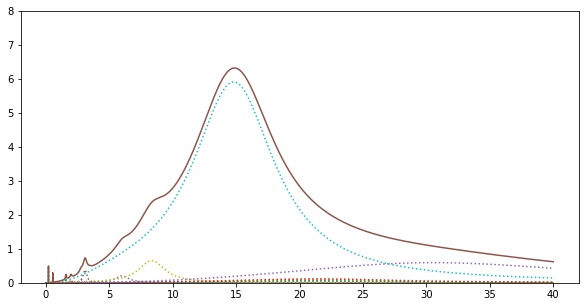

In [50]:
plt.figure(figsize=(10,5))
plt.ylim(0,8)
for elem in plots:
    plt.plot(Ex, elem, ls=':')
plt.plot(Ex, summ_full)
plt.show()

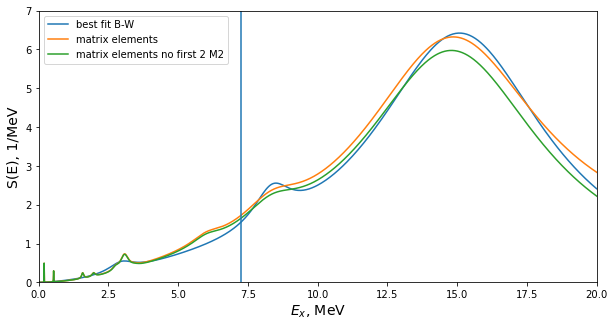

In [51]:
plt.figure(figsize=(10,5))
#plt.plot(decomp_gauss['Ex, MeV'].values, decomp_gauss['bgt'].values, label='bgt')
#plt.plot(decomp_gauss['Ex, MeV'].values, decomp_gauss['best_fit'].values, label='best fit gauss')
plt.plot(decomp['Ex, MeV'].values, decomp['best_fit'].values, label='best fit B-W')
plt.plot(Ex, summ_full, label='matrix elements')
plt.plot(Ex, summ, label='matrix elements no first 2 M2')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.axvline(S_n)
plt.xlim(0,20)
plt.ylim(0,7)
plt.legend()
plt.show()

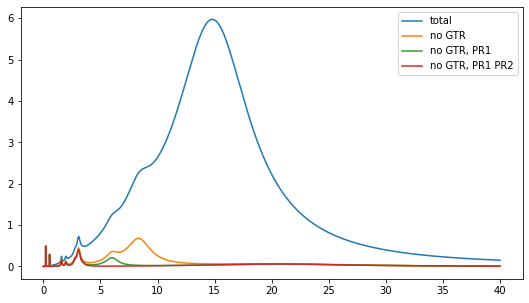

In [52]:
summ_border = border_func(Ex, summ, S_n)
summ_noGTR = summ - plots[9]
summ_noGTR_border = border_func(Ex, summ_noGTR, S_n)
summ_noGTR_PR1 = summ_noGTR - plots[8]
summ_noGTR_PR1_border = border_func(Ex, summ_noGTR_PR1, S_n)
summ_noGTR_PR1_2 = summ_noGTR_PR1 - plots[7] #- plots[6]  - plots[5]   - plots[4]  - plots[3]

plt.figure(figsize=(9,5))
plt.plot(Ex, summ, label='total')
plt.plot(Ex, summ_noGTR, label='no GTR')
plt.plot(Ex, summ_noGTR_PR1, label='no GTR, PR1')
plt.plot(Ex, summ_noGTR_PR1_2, label='no GTR, PR1 PR2')
plt.legend()
plt.show()

In [53]:
trapz(border_func(Ex, summ, 0.3), Ex)

0.005694299999999997

### total

In [54]:
#sigma_pr2_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
#                                      decomp['pr2'].values, Janecki_func, 200) for p in p_list]


sigma_matr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ, Janecki_func, 200) for p in p_list]

sigma_matr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_border, Janecki_func, 200) for p in p_list]

sigma_matr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [54]:
### BS05OP
rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 28.685060214641812,
 'hep': 0.12407782064003034,
 'n13': 0.04120525755238649,
 'o15': 0.1928540099012273,
 'f17': 0.004901370812128785,
 'pep': 0.3142943043896193,
 'Be': 0.561994887710779,
 'Total': 29.924387865647983}

In [55]:
### BS05OP
rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 28.685060214641812,
 'hep': 0.12407782064003034,
 'n13': 0.04120525755238649,
 'o15': 0.1928540099012273,
 'f17': 0.004901370812128785,
 'pep': 0.3142943043896193,
 'Be': 0.561994887710779,
 'Total': 29.924387865647983}

In [56]:
rate_calc(sigma_matr_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 33.880053762365996,
 'hep': 0.21001491100310912,
 'n13': 0.04120525755238649,
 'o15': 0.1928540099012273,
 'f17': 0.004901370812128785,
 'pep': 0.3142943043896193,
 'Be': 0.561994887710779,
 'Total': 35.20531850373524}

### no GTR

In [57]:
sigma_matr_noGTR_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR, Janecki_func, 200) for p in p_list]

sigma_matr_noGTR_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_border, Janecki_func, 200) for p in p_list]

sigma_matr_noGTR_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                         fp=sigma_matr_noGTR_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [58]:
### BS05OP
rate_calc(sigma_matr_noGTR_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 9.188706309922436,
 'hep': 0.037064691729744303,
 'n13': 0.038773610531723554,
 'o15': 0.16318480362086266,
 'f17': 0.004141451751670184,
 'pep': 0.2607653843185996,
 'Be': 0.5449876158301359,
 'Total': 10.237623867705173}

In [59]:
rate_calc(sigma_matr_noGTR_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 10.45288619756975,
 'hep': 0.05192325702636202,
 'n13': 0.038773610531723554,
 'o15': 0.16318480362086266,
 'f17': 0.004141451751670184,
 'pep': 0.2607653843185996,
 'Be': 0.5449876158301359,
 'Total': 11.516662320649104}

### no GTR no PR1

In [60]:
sigma_matr_noGTR_noPR1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1, Janecki_func, 200) for p in p_list]

sigma_matr_noGTR_noPR1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_noPR1_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_noPR1_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1_border, Janecki_func, 200) for p in p_list]

sigma_matr_noGTR_noPR1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                   fp=sigma_matr_noGTR_noPR1_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [61]:
### BS05OP
rate_calc(sigma_matr_noGTR_noPR1_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 6.149350796785331,
 'hep': 0.023092377194753527,
 'n13': 0.037881473995092924,
 'o15': 0.1526610643302199,
 'f17': 0.0038720586385826636,
 'pep': 0.2417103054332303,
 'Be': 0.5387481458499238,
 'Total': 7.147316222227134}

In [62]:
rate_calc(sigma_matr_noGTR_noPR1_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 6.226628058627832,
 'hep': 0.024081089613076416,
 'n13': 0.037881473995092924,
 'o15': 0.1526610643302199,
 'f17': 0.0038720586385826636,
 'pep': 0.2417103054332303,
 'Be': 0.5387481458499238,
 'Total': 7.225582196487958}

### no GTR no PR1 no PR2

In [63]:
sigma_matr_noGTR_noPR1_2_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1_2, Janecki_func, 200) for p in p_list]

sigma_matr_noGTR_noPR1_2_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_noPR1_2_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)


<ipython-input-64-b3b0313e7e1f>:29: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_no_border_full / sigma_matr_no_border_full, c = 'red', ls = '-', )
<ipython-input-64-b3b0313e7e1f>:30: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_no_border_full / sigma_matr_no_border_full, c = 'blue', ls = '-', )
<ipython-input-64-b3b0313e7e1f>:31: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_2_no_border_full / sigma_matr_no_border_full, c = 'blue', ls = '-', )


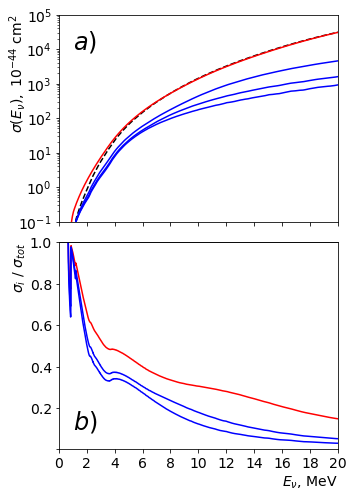

In [64]:
fig = plt.figure(figsize=(5,8))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
ax0.plot(Energy_all_fluxes, sigma_matr_no_border_full, c = 'k', ls = '--', label='1')

ax0.plot(Energy_all_fluxes, sigma_y_tot125_no_border_full, c = 'red', ls = '-', label='1')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_no_border_full, c = 'blue', ls = '-', label='2')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_no_border_full, c='blue', ls='-', label='3')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_2_no_border_full, c='blue', ls='-', label='3')
#ax0.set_ylabel("$F(E,Z)$", fontsize=20)
ax0.set_ylabel('$\sigma(E_{\\nu}),$ $10^{-44}$ cm$^2$', fontsize=14, loc='top')
ax0.set_ylim(10**(-1), 10**(5))
#ax0.set_xlabel("E, keV")
#ax0.set_ylim(0,20)
ax0.set_yscale('log')


ax0.tick_params(axis='both', which='major', labelsize=14)
ax0.tick_params(axis='both', which='minor', labelsize=14)

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
#ax1.plot(Energy_all_fluxes, sigma_matr_no_border_full / sigma_matr_no_border_full, c = 'k', ls = '-',)
ax1.hlines(1, 0, 20, color = 'k', ls = '-',)
ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_no_border_full / sigma_matr_no_border_full, c = 'red', ls = '-', )
ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_no_border_full / sigma_matr_no_border_full, c = 'blue', ls = '-', )
ax1.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_2_no_border_full / sigma_matr_no_border_full, c = 'blue', ls = '-', )
ax1.set_xlabel('$E_{\\nu}$, MeV', fontsize=14, loc='right')
ax1.set_ylabel("$\sigma_i$ / $\sigma_{tot}$", fontsize=14, loc='top')

ax0.yaxis.set_label_coords(-0.11,1)
ax1.yaxis.set_label_coords(-0.11,1)

#ax1.set_xlim(10,10000)
ax1.set_ylim(0,1)
ax1.set_yticks(np.arange(0,1.1,0.2))
plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)
#ax1.set_xscale('log')

# put lened on first subploсt
#ax0.legend((line0, line1), ('red line', 'blue line'), loc='lower left')
#ax0.legend(fontsize=18)
#ax1.legend(loc='lower right', fontsize=18, ncol=4)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

ax0.text( 1, 10**4, '$a)$', fontsize=24,)
ax1.text( 1, 0.1, '$b)$', fontsize=24,)
#ax1.text(-30, -1, 'b)', fontsize=16)

ax0.set_xlim(0,20)
ax1.set_xlim(0,20)
ax1.set_xticks(np.arange(0,22,2))

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)
#plt.tight_layout()
plt.savefig("fig3_prelim.jpg", format='jpg', bbox_inches='tight', transparent=False, dpi=210)

plt.show()

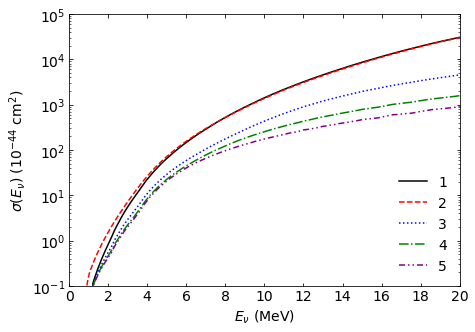

In [67]:
fig, ax0 = plt.subplots(figsize=(7,5))
ax0.plot(Energy_all_fluxes, sigma_matr_no_border_full, c = 'k', ls = '-', label='1')

ax0.plot(Energy_all_fluxes, sigma_y_tot125_no_border_full, c = 'red', ls = '--', label='2')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_no_border_full, c = 'blue', ls = ':', label='3')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_no_border_full, c='green', ls='-.', label='4')
ax0.plot(Energy_all_fluxes, sigma_matr_noGTR_noPR1_2_no_border_full, c='purple', ls=(0, (4, 2, 1, 2, 1, 2)), label='5')
#ax0.set_ylabel("$F(E,Z)$", fontsize=20)
ax0.set_ylabel('$\sigma(E_{\\nu})$ ($10^{-44}$ cm$^2$)', fontsize=14, loc='center')
ax0.set_ylim(10**(-1), 10**(5))
#ax0.set_xlabel("E, keV")
#ax0.set_ylim(0,20)
ax0.set_yscale('log')


ax0.tick_params(direction='in', axis='both', which='major', labelsize=14, top=True, right=True)
ax0.tick_params(direction='in', axis='both', which='minor', labelsize=14, top=True, right=True)

ax0.set_xlabel('$E_{\\nu}$ (MeV)', fontsize=14, loc='center')

#ax1.set_xlim(10,10000)

ax0.legend(loc='lower right', frameon=False, fontsize=14)



ax0.set_xlim(0,20)
ax0.set_xticks(np.arange(0,22,2))

#plt.tight_layout()
plt.savefig("fig3_v2.eps", format='eps', bbox_inches='tight', transparent=False, dpi=300)
#plt.savefig("fig3_v2.jpg", format='jpg', bbox_inches='tight', transparent=False, dpi=300)

plt.show()

<ipython-input-58-50198dfae520>:2: RuntimeWarning: invalid value encountered in true_divide
  ax0.plot(Energy_all_fluxes, sigma_y_tot125_no_border_full / sigma_matr_no_border_full, c = 'k', ls = '-', label='1')


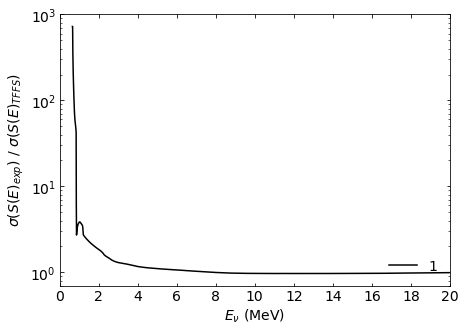

In [58]:
fig, ax0 = plt.subplots(figsize=(7,5))
ax0.plot(Energy_all_fluxes, sigma_y_tot125_no_border_full / sigma_matr_no_border_full, c = 'k', ls = '-', label='1')
#ax0.set_ylabel("$F(E,Z)$", fontsize=20)
ax0.set_ylabel('$\sigma(S(E)_{exp})$ / $\sigma(S(E)_{TFFS})$', fontsize=14, loc='center')
#ax0.set_ylim(10**(-1), 10**(5))
#ax0.set_xlabel("E, keV")
#ax0.set_ylim(0,20)

ax0.set_yscale('log')

ax0.tick_params(direction='in', axis='both', which='major', labelsize=14, top=True, right=True)
ax0.tick_params(direction='in', axis='both', which='minor', labelsize=14, top=True, right=True)

ax0.set_xlabel('$E_{\\nu}$ (MeV)', fontsize=14, loc='center')

#ax1.set_xlim(10,10000)

ax0.legend(loc='lower right', frameon=False, fontsize=14)



ax0.set_xlim(0,20)
ax0.set_xticks(np.arange(0,22,2))

#plt.tight_layout()
#plt.savefig("fig3_v2.eps", format='eps', bbox_inches='tight', transparent=False, dpi=300)
#plt.savefig("fig3_v2.jpg", format='jpg', bbox_inches='tight', transparent=False, dpi=300)

plt.show()